# Task 1

1.a)  Simulate the trajectory of a ball with the parameters launch position (especially the height
above an imaginary ground), launch speed and launch angle of the ball

In [71]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

### Define here all the launch variables

In [72]:
# Define the launch variables
x0 = 0
y0_height = 10.0  # height from the ground in meters
v0_speed = 40.0  # speed of the ball in m/s
theta_0_angle = 45.0  # launch angle in degrees

# gravity in m/s^2 
g = 9.81  

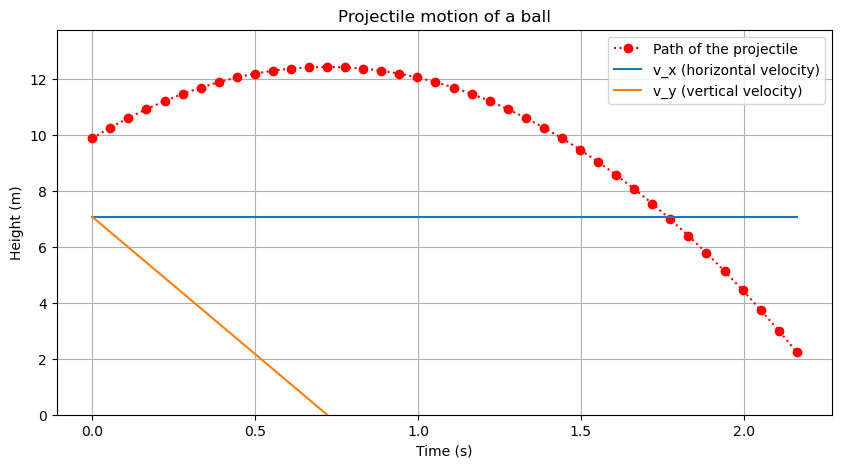

In [73]:
theta_0_angle = 45.0  # launch angle in degrees
v0_speed = 10.0  # speed of the ball in m/s
y0_height = 10.0  # height from the ground in meters
# Convert the launch angle to radians
angle_rad = np.deg2rad(theta_0_angle)

# Calculate the total time of flight
time_flight = (3*v0_speed*np.sin(angle_rad))/g

# Calculate the horizontal distance (range)
range_ball = v0_speed*np.cos(angle_rad)*time_flight

# Sample 
num = 40

# Generate time points
delta_t = np.linspace(0, time_flight, num)  # generate time points

# Calculate the x and y coordinates
x_real = v0_speed*np.cos(angle_rad)*delta_t + np.random.normal(0,0.1)
y_real = y0_height + v0_speed*np.sin(angle_rad)*delta_t - 0.5*g*delta_t**2 + np.random.normal(0,0.1)

# Calculate the x and y components of velocity
v_x = v0_speed*np.cos(angle_rad)  # constant
v_y = v0_speed*np.sin(angle_rad) - g*delta_t

# Calculate the velocity
velocity = np.sqrt(v_x**2 + v_y**2)  # magnitude of velocity

# Plot the trajectory
plt.figure(figsize=(10,5))
plt.plot(delta_t, y_real,'o:r', label='Path of the projectile')

plt.plot(delta_t, v_x*np.ones_like(delta_t), label='v_x (horizontal velocity)')  # plot Vx
plt.plot(delta_t, v_y, label='v_y (vertical velocity)')  # plot Vyy

plt.title('Projectile motion of a ball')
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.grid(True)
plt.ylim(bottom=0)
plt.legend()
plt.show()

1.b) 
- Simulate the observation of the ball position (x, y as shown in the slides).
- The estimatedball position shall be subject to uncertainty and it shall be possible to parameterize this uncertainty. 
- In addition, the time span between two observations shall be variable and the observations shall be able to drop out completely over a certain period of time.
    - this cause reduction of the KF ability and rely more on the model predictions. 

In [74]:
# importing the important libraries 
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

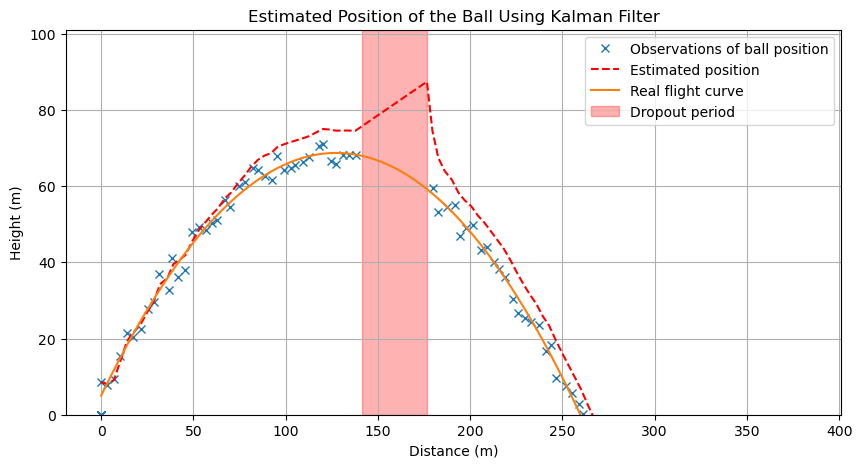

In [76]:
# importing the important libraries 
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
# Define time step a
dt = 0.1
# initial speed
v0 = 50.
y0 = 5.

# gravity in m/s^2 
g = 9.81 

theta_0_angle = 45.0  # launch angle in degrees
angle_rad = np.deg2rad(theta_0_angle)
x_vel = v0 * np.cos(angle_rad)
y_vel = v0 * np.sin(angle_rad)

#Total time until it raches ground level y = 0
#total_time =  (v0 * np.sin(angle_rad) + np.sqrt((v0 * np.sin(angle_rad))**2 +g * y0)) /g 
total_time = (3*v0*np.sin(angle_rad))/g
# Define initial state
# [x_pos, y_pos, x_vel, y_vel]
q = np.array([0., y0, x_vel , y_vel])  


# Define transition matrix A_t
F_t= np.array([[1., 0, dt,  0],
              [0,  1., 0,  dt],
              [0,  0, 1., 0],
              [0,  0, 0,  1.]])

# Define observation matrix (measurement matrix)
H_t = np.array([[1., 0, 0, 0],
              [0, 1., 0, 0]])

# Define process noise covariance
# Model Prediction noise 
Q = block_diag(Q_discrete_white_noise(dim=2, dt=dt, var=1.),
               Q_discrete_white_noise(dim=2, dt=dt, var=1.))

# Define measurement noise covariance
# Larger R = low trust to my measuremnts
R = np.array([[0.3, 0],
              [0, 0.8]])

# Define initial covariance matrix( this same as np.array([[100.,0], [0., 100.]]))
P0 = np.eye(4) * 1000.

# Initialize the Kalman Filter
kf = KalmanFilter(dim_x=4, dim_z=2)
kf.x = q
kf.F = F_t
kf.H = H_t
kf.Q = Q
kf.R = R
kf.P = P0
#print(f"x: {x}, \nA_t:{A_t},\n C_t:{C_t},\n Q:{Q},\n R:{R},\n PO: {P0}")

# Generate noisy observations
t = np.arange(0, total_time, dt)
n = len(t)

z = np.zeros((n, 2))  # observed position
# Define the start and end time of the dropout 
t_drop_start = 4
t_drop_end = 5
for i in range(n):
     #Check if the current time is within the dropout period 
    if t_drop_start <= t[i] <= t_drop_end:
        continue
    # all the x axes observations
    z[i, 0] = x[0] + x[2]*t[i] + np.random.normal(0, np.sqrt(R[0, 0]))
    # all the y axes observations
    # y = y_0 + v_y * delta_t - 0.5 * g * delta_t ^2 
    z[i, 1] = x[1] + x[3]*t[i] - 0.5*g*t[i]**2 + 3.*np.random.normal(0, np.sqrt(R[1, 1]))
    #print(np.random.normal(0, np.sqrt(R[1, 1])))

# Real Curve
p = np.zeros((n,2))
for i in range(n):
    # all the x axes observations
    p[i, 0] = x[0] + x[2]*t[i] 
    # all the y axes observations
    p[i, 1] = x[1] + x[3]*t[i] - 0.5*g*t[i]**2 

 
# Use Kalman Filter for estimation
x_est = np.zeros((n, 4))  # estimated state
for i in range(n):
    kf.predict()
    if (t_drop_start <= t[i] <= t_drop_end):
        # Increase measurement noise during dropout period
        kf.R = np.array([[1000., 0],
              [0, 1000.]])
    else:
        kf.R = R
        kf.update(z[i])
    x_est[i] = kf.x
    
# [x_pos, y_pos, x_vel, y_vel]

# Plot true and estimated position
plt.figure(figsize=(10,5))
plt.plot(z[:, 0], z[:, 1], 'x', label='Observations of ball position')


plt.plot(x_est[:, 0], x_est[:, 1], 'r--', label='Estimated position')
plt.plot(p[:, 0], p[:, 1], label= "Real flight curve")
#plt.plot(x_real, y_real, label= "Real")

plt.axvspan(t_drop_start * x_vel, t_drop_end * x_vel, color='red', alpha=0.3, label='Dropout period')

plt.title('Estimated Position of the Ball Using Kalman Filter')
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')
plt.ylim(bottom=0)
plt.legend(loc='best')
plt.grid(True)
plt.show()



In [ ]:
# Initialize the Kalman Filter without any pre-dedined functions and libraries    
class KalmanFilter:
        def __init__(self, dim_x, dim_z):
            self.dim_x = dim_x
            self.dim_z = dim_z
            self.x = np.zeros((dim_x, 1))     # state   
            self.P = np.eye(dim_x)            # uncertainty covariance
            self.Q = np.eye(dim_x)            # process uncertainty
            self.B = 0                        # control transition matrix
            self.F = np.eye(dim_x)            # state transition matrix
            self.H = np.zeros((dim_z, dim_x)) # Measurement function
            self.R = np.eye(dim_z)            # state uncertainty
            self.y = np.zeros((dim_z, 1))
            self.S = np.zeros((dim_z, dim_z)) # system uncertainty
            self.K = np.zeros((dim_x, dim_z)) # Kalman gain
            self.z = np.array([[None]*self.dim_z]).T
            self.M = 0                        # process-measurement cross correlation
            self.residual = np.zeros((dim_z, 1))
            self.SI = np.zeros((dim_z, dim_z))# inverse system uncertainty
            self.inv = np.linalg.inv
            self.dot = np.dot
            
        def update(self, z, R=None, H=None):
            """
            Add a new measurement (z) to the Kalman filter. If z is None, nothing
            is changed.
            """
            if z is None:
                return

            if R is None:
                R = self.R
            if H is None:
                H = self.H
            # error (residual) between measurement and prediction
            self.y = z - self.dot(H, self.x)
            # project system uncertainty into measurement space
            self.S = self.dot(H, self.dot(self.P, H.T)) + R
            # map system uncertainty into kalman gain
            self.K = self.dot(self.P, self.dot(H.T, self.inv(self.S)))
            # predict new x with residual scaled by the kalman gain
            self.x = self.x + self.dot(self.K, self.y)
            # P = (I-KH)P(I-KH)' + KRK'
            I_KH = self.I - self.dot(self.K, H)
            self.P = self.dot(I_KH, self.dot(self.P, I_KH.T)) + self.dot(self.K, self.dot(R, self.K.T))
            self.y = np.zeros((self.dim_z, 1))
            
        def predict(self, u=0):
            """
            Predict next position. If there is control input, it is added to the
            prediction. Return the predicted state.
            """
            self.x = self.dot(self.F, self.x) + self.dot(self.B, u)
            self.P = self.dot(self.F, self.dot(self.P, self.F.T)) + self.Q
            return self.x
        def batch_filter(self, zs, Rs=None, Hs=None):
            """
            Batch processes a sequences of measurements.
            Parameters
            ----------
            zs : list-like
                list of measurements at each time step `self.dt`. Missing
                measurements must be represented by 'None'.
            Rs : list-like, optional
                list of values to use for the measurement error covariance `R`.
                A value of None in any position will cause the filter to use `self.R`
                for that time step. Defaults to None.
            Hs : list-like, optional
                list of values to use for the measurement matrix `H`.
                A value of None in any position will cause the filter to use `self.H`
                for that time step. Defaults to None.
            """
            if Rs is None:
                Rs = [None] * len(zs)
            if Hs is None:
                Hs = [None] * len(zs)

            # mean estimates from Kalman Filter
            self.xp = np.zeros((self.dim_x, 1)) # predicted state
            self.Pp = np.zeros((self.dim_x, self.dim_x)) # predicted covariance
            # error (residual) between prior and posterior
            self.y = np.zeros((self.dim_z, 1))
            # system uncertainty prior to update
            self.S = np.zeros((self.dim_z, self.dim_z))
            # system uncertainty prior to update
            self.SI = np.zeros((self.dim_z, self.dim_z))
            # posteriori residual covariance
            self.Ss = np.zeros((self.dim_z, self.dim_z))
            # Kalman gain for each step
            self.Ks = np.zeros((self.dim_x, self.dim_z))
            # save priori residual covariances (S) and Kalman gains (K)
            self.SI_k = []
            self.K_k = []
            for z, r, H in zip(zs, Rs, Hs):
                self.predict()
                self.update(z, r, H)
                self.SI_k.append(self.SI)
                self.K_k.append(self.K)
            # save measurement and state estimate histories
            self.zs = np.array(zs)
            self.xs = np.array(self.xs)
            self.Ps = np.array(self.Ps)
            self.Ks = np.array(self.Ks)
            self.xp = np.array(self.xp)
            self.Pp = np.array(self.Pp)
            self.Ss = np.array(self.Ss)
            self.SI_k = np.array(self.SI_k)
            self.K_k = np.array(self.K_k)
            return (self.xs, self.Ps)
    

In [ ]:
def run_kalman_filter(theta_0 =45.0,v0 = 50.0, y0=5.0, dt =0.1, t_drop_start=3, t_drop_end =4):
    #
    # Define time step  dt 
    # initial speed v0
    # initial height y0
    # launch angle in degrees theta_0
    # gravity in m/s^2 
    g = 9.81 
    angle_rad = np.deg2rad(theta_0)
    x_vel = v0 * np.cos(angle_rad)
    y_vel = v0 * np.sin(angle_rad)

    #Total time until it raches ground level y = 0
    #total_time =  (v0 * np.sin(angle_rad) + np.sqrt((v0 * np.sin(angle_rad))**2 +g * y0)) /g 
    total_time = (3*v0*np.sin(angle_rad))/g
    # Define initial state
    # [x_pos, y_pos, x_vel, y_vel]
    x = np.array([0., y0, x_vel , y_vel])  


    # Define transition matrix A_t
    A_t= np.array([[1., 0, dt,  0],
                [0,  1., 0,  dt],
                [0,  0, 1., 0],
                [0,  0, 0,  1.]])

    # Define observation matrix (measurement matrix)
    C_t = np.array([[1., 0, 0, 0],
                [0, 1., 0, 0]])

    # Define process noise covariance
    # Model Prediction noise 
    Q = block_diag(Q_discrete_white_noise(dim=2, dt=dt, var=1.),
                Q_discrete_white_noise(dim=2, dt=dt, var=1.))

    # Define measurement noise covariance
    # Larger R = low trust to my measuremnts
    R = np.array([[0.1, 0],
                [0, 2]])

    # Define initial covariance matrix( this same as np.array([[100.,0], [0., 100.]]))
    P0 = np.eye(4) * 1000.
    
    
    # Initialize the Kalman Filter
    kf = KalmanFilter(dim_x=4, dim_z=2)
    kf.x = x
    kf.F = A_t
    kf.H = C_t
    kf.Q = Q
    kf.R = R
    kf.P = P0
    #print(f"x: {x}, \nA_t:{A_t},\n C_t:{C_t},\n Q:{Q},\n R:{R},\n PO: {P0}")

    # Generate noisy observations
    t = np.arange(0, total_time, dt)
    n = len(t)

    z = np.zeros((n, 2))  # observed position
    # Define the start and end time of the dropout 
    t_drop_start = 4
    t_drop_end = 5
    for i in range(n):
        #Check if the current time is within the dropout period 
        if t_drop_start <= t[i] <= t_drop_end:
            continue
        # all the x axes observations
        z[i, 0] = x[0] + x[2]*t[i] + np.random.normal(0, np.sqrt(R[0, 0]))
        # all the y axes observations
        # y = y_0 + v_y * delta_t - 0.5 * g * delta_t ^2 
        z[i, 1] = x[1] + x[3]*t[i] - 0.5*g*t[i]**2 + 3.*np.random.normal(0, np.sqrt(R[1, 1]))
        #print(np.random.normal(0, np.sqrt(R[1, 1])))

    # Real Curve
    p = np.zeros((n,2))
    for i in range(n):
        # all the x axes observations
        p[i, 0] = x[0] + x[2]*t[i] 
        # all the y axes observations
        p[i, 1] = x[1] + x[3]*t[i] - 0.5*g*t[i]**2 

    
    # Use Kalman Filter for estimation
    x_est = np.zeros((n, 4))  # estimated state
    for i in range(n):
        kf.predict()
        if (t_drop_start <= t[i] <= t_drop_end):
            # Increase measurement noise during dropout period
            kf.R = np.array([[1000., 0],
                [0, 1000.]])
        else:
            kf.R = R
            kf.update(z[i])
        x_est[i] = kf.x
        
    # [x_pos, y_pos, x_vel, y_vel]

    # Plot true and estimated position
    plt.figure(figsize=(10,5))
    plt.plot(z[:, 0], z[:, 1], 'x', label='Observations of ball position')
    plt.plot(x_est[:, 0], x_est[:, 1], 'r--', label='Estimated position')
    plt.plot(p[:, 0], p[:, 1], label= "Real flight curve")
    #plt.plot(x_real, y_real, label= "Real")

    plt.axvspan(t_drop_start * x_vel, t_drop_end * x_vel, color='red', alpha=0.3, label='Dropout period')

    plt.title('Estimated Position of the Ball Using Kalman Filter')
    plt.xlabel('Distance (m)')
    plt.ylabel('Height (m)')
    #plt.ylim(bottom=0)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()



In [ ]:
run_kalman_filter(theta_0 =45.0,v0 = 50.0, y0=5.0, dt =0.1, t_drop_start=3, t_drop_end =4)

AttributeError: 'KalmanFilter' object has no attribute 'I'

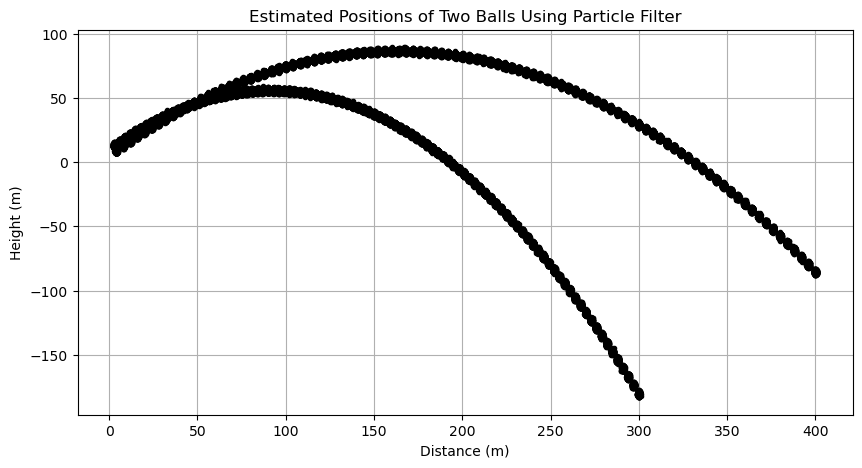

In [ ]:
def propagate_particles(particles, dt, g):
    """Propagate particles according to physics laws."""
    for particle in particles:
        particle["x"] += particle["vx"] * dt
        particle["y"] += particle["vy"] * dt - 0.5 * g * dt**2
        particle["vy"] -= g * dt

def observe_particles(particles, x_noise, y_noise):
    """Generate observations of particles with noise."""
    observations = []
    for particle in particles:
        x_obs = particle["x"] + np.random.normal(0, x_noise)
        y_obs = particle["y"] + np.random.normal(0, y_noise)
        observations.append({"x": x_obs, "y": y_obs})
    return observations

def particle_filter(n_particles, initial_conditions, dt, g, x_noise, y_noise):
    """Run a particle filter."""
    # Initialize particles
    particles = []
    for i in range(n_particles):
        for j in range(2): # Two balls
            particles.append(initial_conditions[j].copy())
    
    # Propagate and observe particles over time
    observations_over_time = []
    for i in range(n_time_steps):
        propagate_particles(particles, dt, g)
        observations = observe_particles(particles, x_noise, y_noise)
        observations_over_time.append(observations)
    
    return observations_over_time

# Define parameters
n_particles = 1000
n_time_steps = 100
dt = 0.1
g = 9.81
x_noise = 0.3
y_noise = 0.8

# Define initial conditions for the two balls
initial_conditions = [{"x": 0.0, "y": 5.0, "vx": 40.0, "vy": 40.0},
                      {"x": 0.0, "y": 10.0, "vx": 30.0, "vy": 30.0}]

# Run particle filter
observations_over_time = particle_filter(n_particles, initial_conditions, dt, g, x_noise, y_noise)

# Plot observations
plt.figure(figsize=(10, 5))
for i in range(n_time_steps):
    observations = observations_over_time[i]
    for obs in observations:
        plt.plot(obs["x"], obs["y"], 'k.')
plt.title('Estimated Positions of Two Balls Using Particle Filter')
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')
plt.grid(True)
plt.show()
